# Word2Vec

Модель Word2Vec является еще одним способом получения векторного представления для слов в тексте. Эти векторные представления называются эмбеддинги. Модель можно реализовать двумя способами: через CBOW (Continious Bag-of-words) и с помощью Skip-Grams. Отличие между ними состоит в том, что в первом случае мы пытаемся на основе контекста предсказать слово, а во втором - на основе слова предсказать окружающий контекст. 

![CBOW_SkipGram](images/cbow_skipgram.png)

Рассмотрим эти алгоритмы подробнее.

### Skip-Gram

Пусть мы решаем следующую задачу. Дано конкретное слово в середине предложения (входное слово). Алгоритм наугад выбирает одно слово из близких к входному и для каждого слова в словаре предсказывает вероятность того, что наугад выбрали именно его. Предсказания показывают, насколько вероятно найти то или иное слово возле входного. 

![SkipGram_architecture](images/skipgram_architecture.png)

Пусть N - размерность словаря. Представим каждое слово в виде one-hot вектора (состоящего из 0 и 1, где 1 - выбранное слово). Он будет кодировать слово по положению в словаре. Теперь подадим его на скрытый слой нейросети и преобразуем его в новый, семантический, вектор. Новый вектор попадает на выходной слой и умножается на N наборов разных чисел (уникальный для каждого из N слов в словаре). Затем с помощью функции Softmax каждый получившийся набор превращается в число между 0 и 1 — выходное число. Сумма N выходных чисел даёт единицу. Каждое из выходных чисел показывает, какова вероятность встретить слово данного выходного нейрона рядом с изначально заданным словом.

Теперь рассмотрим подробнее работу скрытого слоя. Здесь нам требуется сформировать семантический вектор из ограниченного количества признаков (как правило 300, именно столько было в реализации от Google). Для перехода в скрытый слой one-hot вектор умножается на матрицу весов размером N * 300. По сути, умножение такого вектора на матрицу равносильно выбору соответствующей строки в ней. Получение значений в матрице весов является целью обучения нейросети.

### CBOW (Continious Bag-of-words)

В случае с CBOW (Continious Bag-of-words) мы решаем обратную задачу: семантический вектор формируется таким образом, чтобы по поданному на вход контексту определить, какое слово вероятнее всего должно быть выбрано. Модель представляет собой нейронную сеть прямого распространения со следующей архитектурой:

1. Входной слой: представляет контекст слов. Его размер определяется размером контекстного окна.
2. Проекционный слой: каждое входное слово преобразуется в вектор фиксированного размера, или эмбеддинг. 
3. Скрытый слой: как и в Skip-Gram модели, он должен уметь извлекать связь между целевым словом и его контекстом.
4. Выходной слой имеет столько нейронов, сколько слов в словаре. С помощью функции Softmax определяется вероятность встретить слово данного выходного нейрона в заданном контексте.

Рассмотрим пример построения модели Word2Vec на практике и попробуем решить задачу классификации, опираясь на полученные эмбеддинги.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gensim  # реализация Word2Vec

from tqdm import tqdm

from text_transformer import TextTransformer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE  # алгоритм понижения размерности

In [3]:
sns.set_theme()
tqdm.pandas()

In [4]:
DATA_PATH = "data/train.csv"
STOP_WORDS = 'data/stop_words.txt'
RANDOM_STATE = 42  # для фиксации генератора случайных чисел
SIZE = 100  # размер эмбеддинга

Загрузим данные и сделаем предобработку текста с помощью препроцессора, написанного нами ранее. После этого разобьем данные на обучающую и валидационную выборку. 

In [5]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


In [6]:
with open(STOP_WORDS, encoding='utf-8') as file:
    stop_words = [w.strip() for w in file.readlines()]

### Анализ и предобработка данных

In [7]:
text_tf = TextTransformer(stop_words)
df = text_tf.fit_transform(df)
df['cleaned'] = df['cleaned'].apply(lambda x: gensim.utils.simple_preprocess(x)) # разобьем слова на токены
df.head()

100%|██████████| 15449/15449 [01:58<00:00, 130.19it/s]


,text,class,doc,num_tokens,num_sentences,cleaned
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,Doc(text='проблема: не открывается АКТ сверки ...,15,1,открываться акт сверка сбс пакет документ ска...
1,В случае выбора неверного шаблона просьба указ...,1-70,Doc(text='В случае выбора неверного шаблона пр...,81,4,случай выбор неверный шаблон указать наименова...
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,Doc(text='Вопрос/информация Добрый день! В ЗНВ...,39,2,информация знв графа сумма комиссия необходим...
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,Doc(text='Вопрос/проблема: После выхода из отп...,90,6,выход отпуск .. меню увхд стать короче полагат...
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,Doc(text='В УВХД необходимо снять резервирован...,61,4,увхд необходимый снять резервирование знс да...


In [9]:
X_train, X_val, y_train, y_val = train_test_split(df['cleaned'], df['class'], test_size=0.33, random_state=RANDOM_STATE)

Создадим модель Word2Vec для обучающей выборки. Зададим следующие параметры:
- vector_size - размерность будущих эмбеддингов
- window - размер скользящего окна, определяет максимальное расстояние в тексте между заданным словом и предсказанным
- min_count - минимальное количество раз появления слова в корпусе, чтобы для него был построен эмбеддинг
- seed - фиксация генератора случайных чисел для воспроизводимости результатов
- workers - количество потоков, которые используются для обучения модели. Для воспроизводимости результатов их рекомендуется ограничить до 1, согласно документации модели.

По умолчанию используется Skip-Gram модель, но ее можно изменить на CBOW, установив параметр ```sg=0```.

In [10]:
w2v_model = gensim.models.Word2Vec(
    X_train,
    vector_size=SIZE,
    window=5,
    min_count=15,
    seed=RANDOM_STATE,
    workers=1
)

Посмотреть слова, вошедшие в словарь модели, можно с помощью атрибута ```index_to_key```. Выведем первые 10 слов:

In [11]:
w2v_model.wv.index_to_key[:10]

['договор',
 'знс',
 'ошибка',
 'необходимый',
 'создать',
 'заявка',
 'командировка',
 'увхд',
 'сотрудник',
 'данный']

Построим визуализацию эмбеддингов для первых 30 слов. Для этого потребуется алгоритм понижения размерности TSNE, который позволит перейти от пространства размерности SIZE к двумерному.

In [12]:
words = list(set(w2v_model.wv.index_to_key))

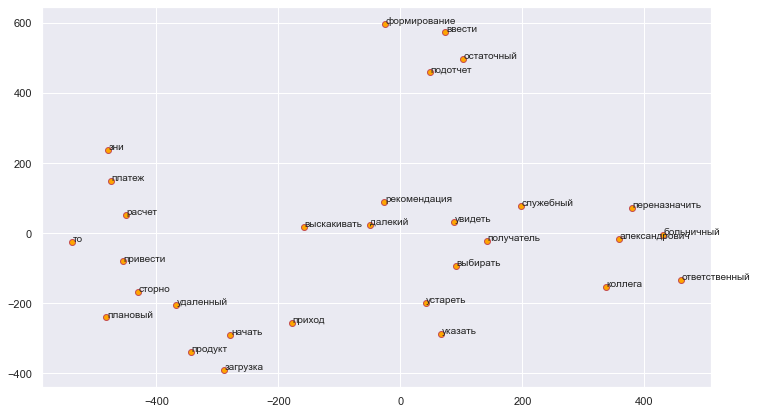

In [13]:
wvs = w2v_model.wv[words[:30]]

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)

labels = words[:30]
plt.figure(figsize=(12, 7));
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r');
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points');

Из графика видно, какие слова чаще встречаются вместе, а какие - наоборот. Таким образом, модель выучивает контекст употреления разных слов в корпусе текстов.

Посмотрим, как выглядят эббеддинги для первых 30 слов:

In [14]:
vec_df = pd.DataFrame(wvs, index=words[:30])
vec_df.style.background_gradient(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
указать,-0.010604,-0.084842,0.085107,0.159161,0.186328,0.537045,0.234622,0.037830,-0.127137,0.217925,-0.579486,-0.263731,0.167506,0.298525,0.128553,-0.122270,-0.302223,-0.455859,0.017697,0.608091,0.442613,0.121172,-0.254412,0.083838,0.447588,0.199336,-0.001848,0.469890,0.287178,-0.497324,-0.480948,0.178060,0.067597,-0.065025,-0.336288,0.269989,0.335843,-0.218084,-0.039397,0.451374,0.014638,-0.467052,0.267451,-0.433287,0.192080,0.186940,-0.034709,0.088184,0.327714,0.048499,-0.263616,-0.434429,-0.217541,-0.235606,0.341526,0.380672,0.523403,0.580826,-0.262835,0.567552,-0.317822,0.155924,-0.470894,0.094334,0.130419,0.550895,-0.047991,-0.027829,-0.465819,0.030537,0.002145,0.082671,-0.033574,0.197598,0.149504,0.157695,-0.150670,-0.473587,-0.097474,-0.152724,0.064454,-0.095772,-0.446508,-0.061098,-0.420426,-0.040508,0.266878,-0.392979,-0.575708,0.318131,-0.296942,0.308197,-0.064906,-0.353031,0.245651,-0.230555,-0.202931,-0.523944,-0.682616,0.147026
получатель,0.164340,0.027495,-0.069885,0.072965,-0.282626,0.152027,0.340413,0.096876,-0.054039,-0.015585,-0.345388,0.011500,0.142681,0.206214,-0.152144,-0.194095,0.097039,-0.311487,-0.131505,-0.087053,-0.008325,0.100054,0.028224,0.329892,0.078656,-0.038942,-0.199947,0.033009,0.008821,-0.212166,-0.099302,-0.054836,0.212054,0.012541,0.005807,0.045654,0.047086,-0.403199,-0.009266,0.210258,0.124210,0.103669,0.332434,-0.155630,0.048870,-0.067726,0.175193,0.169162,0.342938,-0.165901,-0.126193,-0.464681,0.027410,0.052406,0.154190,-0.009768,-0.052738,0.218224,-0.115770,0.240536,-0.244577,-0.097792,-0.268285,0.144856,0.144308,0.088491,0.091645,-0.146869,-0.193950,0.254529,-0.019777,0.049145,0.002398,-0.124675,-0.040217,-0.133219,0.000184,-0.080427,-0.110125,-0.139990,-0.000786,-0.084754,-0.103250,0.123223,-0.278851,0.049593,0.097629,-0.327271,-0.207618,0.081841,-0.469320,0.370240,-0.019733,-0.261933,0.058755,-0.056958,0.086375,0.239825,-0.338986,0.002856
удаленный,0.157735,-0.030892,0.005925,0.069903,-0.125554,0.130401,0.207822,0.086967,-0.077495,-0.034301,-0.170981,0.035807,0.005181,0.191911,-0.114968,-0.083781,0.080146,-0.153922,-0.016048,-0.092043,-0.002889,0.098800,0.115482,0.145829,0.048263,-0.002238,-0.154776,0.056128,-0.037002,-0.110601,-0.092003,-0.048552,0.105857,-0.035812,0.021964,0.045501,0.005214,-0.247537,-0.016349,0.057940,0.054901,0.031989,0.238735,-0.075687,0.072183,0.039050,0.087255,0.137480,0.219942,-0.088532,-0.029971,-0.303169,0.030382,-0.010621,0.133978,-0.060417,-0.097675,0.072055,-0.101777,0.117799,-0.069132,-0.078963,-0.147067,0.134350,0.090543,-0.004493,0.028557,-0.118152,-0.123591,0.080952,-0.028433,0.057280,0.068887,-0.046013,-0.026007,-0.068956,0.090844,-0.040817,-0.061184,-0.108952,0.050451,-0.093809,-0.057312,0.059100,-0.238828,-0.012654,0.031046,-0.215608,-0.069720,0.078233,-0.230948,0.186283,0.049888,-0.245801,0.152379,-0.029951,-0.040607,0.138853,-0.126678,-0.023332
продукт,0.094053,0.032938,-0.067422,0.036906,-0.141833,0.114189,0.197635,0.073616,-0.067175,-0.021076,-0.183651,-0.019734,0.080041,0.137080,-0.100584,-0.061235,0.058487,-0.165947,-0.053228,-0.066460,0.043207,0.097638,-0.024740,0.106626,0.027273,-0.010334,-0.103976,-0.012317,-0.000917,-0.074249,-0.051533,-0.020041,0.098870,-0.030137,0.028389,0.076078,0.043176,-0.242337,-0.030669,0.118398,0.018109,0.078752,0.150083,-0.104877,0.049401,-0.044555,0.107875,0.062499,0.111461,-0.101925,-0.113863,-0.248727,0.066062,0.027090,0.122568,-0.039390,-0.042410,0.087352,-0.114238,0.170512,-0.148408,-0.089432,-0.168713,0.087945,0.036321,0.051778,0.078454,-0.101213,-0.119891,0.133090,-0.020850,0.042718,0.010492,-0.061658,-0.075728,-0.110879,-0.061391,0.016751,-0.021808,-0.025468,-0.038856,-0.091838,-0.027490,0.121163,-0.161779,0.019810,-0

Также можно понять, какие слова чаще встречаются вместе, посчитав косинусное расстояние между векторами. Для первых 30 слов матрица косинусных расстояний выглядит следующим образом:

In [15]:
similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=vec_df.index, columns=vec_df.index)
similarity_df.style.background_gradient()

,указать,получатель,удаленный,продукт,ввести,подотчет,выбирать,привести,больничный,начать,увидеть,плановый,далекий,александрович,ответственный,то,устареть,расчет,остаточный,зни,коллега,служебный,платеж,рекомендация,сторно,формирование,загрузка,переназначить,выскакивать,приход
указать,1.000000,0.542554,0.477962,0.487688,0.575303,0.576252,0.592144,0.499215,0.458964,0.488675,0.523702,0.520001,0.535993,0.526506,0.314528,0.513685,0.726588,0.310171,0.542173,0.234305,0.456117,0.386666,0.059602,0.597695,0.462495,0.413192,0.421377,0.486110,0.442841,0.559686
получатель,0.542554,1.000000,0.918427,0.945888,0.689957,0.784816,0.964150,0.881246,0.940338,0.987146,0.967827,0.877400,0.942163,0.949770,0.484180,0.901960,0.899909,0.789920,0.762552,0.404617,0.729629,0.923604,0.315646,0.933705,0.877938,0.569043,0.930548,0.927656,0.817933,0.885423
удаленный,0.477962,0.918427,1.000000,0.881468,0.669510,0.678300,0.851302,0.949882,0.814885,0.936210,0.885601,0.909761,0.896469,0.803135,0.226189,0.955325,0.809063,0.884074,0.717377,0.588655,0.596127,0.885511,0.594006,0.912479,0.966355,0.476038,0.876691,0.816536,0.855709,0.842308
продукт,0.487688,0.945888,0.881468,1.000000,0.585792,0.778250,0.905715,0.875989,0.862247,0.952267,0.901229,0.836087,0.836459,0.894853,0.452706,0.898185,0.867085,0.829187,0.754759,0.215832,0.719985,0.962616,0.276833,0.877998,0.829812,0.417006,0.933525,0.848425,0.700403,0.863902
ввести,0.575303,0.689957,0.669510,0.585792,1.000000,0.856426,0.752860,0.597892,0.552804,0.689306,0.590639,0.580308,0.705783,0.558798,0.130444,0.647817,0.804222,0.462084,0.904512,0.363275,0.179162,0.496413,0.193320,0.626769,0.639036,0.745599,0.458862,0.496262,0.698217,0.826834
подотчет,0.576252,0.784816,0.678300,0.778250,0.856426,1.000000,0.843643,0.649018,0.651599,0.771726,0.682576,0.633344,0.709847,0.674368,0.288954,0.703918,0.906886,0.526800,0.957693,0.066101,0.403224,0.674730,0.015071,0.682718,0.641039,0.718246,0.629362,0.587336,0.623916,0.938839
выбирать,0.592144,0.964150,0.851302,0.905715,0.752860,0.843643,1.000000,0.827680,0.895477,0.949482,0.918788,0.783851,0.942390,0.929617,0.472975,0.847515,0.921012,0.679890,0.813525,0.363132,0.639964,0.852839,0.189653,0.933032,0.811904,0.638329,0.874928,0.873449,0.835801,0.926191
привести,0.499215,0.881246,0.949882,0.875989,0.597892,0.649018,0.827680,1.000000,0.730463,0.900296,0.888597,0.922303,0.891279,0.763078,0.176197,0.971818,0.805880,0.924131,0.662422,0.499472,0.641774,0.864298,0.633961,0.902616,0.972694,0.496301,0.908932,0.746495,0.870051,0.821620
больничный,0.458964,0.940338,0.814885,0.862247,0.552804,0.651599,0.895477,0.730463,1.000000,0.923513,0.926461,0.758512,0.877144,0.977455,0.666902,0.766167,0.764919,0.655809,0.599709,0.425774,0.770440,0.872520,0.194663,0.877912,0.742055,0.435378,0.868837,0.988467,0.711893,0.753546
начать,0.488675,0.987146,0.936210,0.952267,0.689306,0.771726,0.949482,0.900296,0.923513,1.000000,0.956840,0.870989,0.932049,0.929452,0.446428,0.913696,0.866242,0.838361,0.766974,0.420018,0.705556,0.948861,0.379017,0.934557,0.895887,0.551108,0.939324,0.913605,0.826857,0.888157


Выведем 3 самых часто встречающихся слова для входного слова:

In [16]:
feature_names = np.array(list(words)[:30])
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]], axis=1)

указать                  [устареть, рекомендация, выбирать]
получатель                      [начать, увидеть, выбирать]
удаленный                            [сторно, то, привести]
продукт                     [служебный, начать, получатель]
ввести                       [остаточный, подотчет, приход]
подотчет                     [остаточный, приход, устареть]
выбирать                      [получатель, начать, далекий]
привести                            [сторно, то, удаленный]
больничный       [переназначить, александрович, получатель]
начать                       [получатель, увидеть, продукт]
увидеть                      [получатель, загрузка, начать]
плановый                             [то, сторно, привести]
далекий                   [рекомендация, увидеть, выбирать]
александрович       [больничный, переназначить, получатель]
ответственный    [александрович, больничный, переназначить]
то                            [привести, сторно, удаленный]
устареть                       [выбирать

Попробуем обучить классификатор на эмбеддингах Word2Vec. Сначала векторизуем каждый из текстов. Если слово встречается в словаре, заменим его на соответствующий эмбеддинг.

In [17]:
X_train_vectorised = X_train.apply(lambda x: np.array([w2v_model.wv[i] for i in x if i in words]))

В результате мы получили трехмерный тензор с признаками. Посмотрим представление первого текста в корпусе. Оно представляет собой матрицу (Количество слов в тексте * SIZE):

In [18]:
X_train_vectorised.iloc[0].shape

(22, 100)

Теперь нам требуется перейти к векторному представлению всего текста от векторных представлений отдельного слова. Для этого можно усреднить по столбцам и получить в результате векторное представление текста размера SIZE:

In [19]:
X_train_avg = X_train_vectorised.apply(lambda v: v.mean(axis=0) if v.size else np.zeros(SIZE, dtype=float))

In [20]:
X_train_avg.iloc[0].shape

(100,)

Так как все операции выполнялись с помощью pandas над numpy-массивами, требуется сделать еще одно преобразование, чтобы исправить проблему со сбившимися размерностями матрицы. После этого можно приступать к обучению.

In [21]:
X_train_avg_arr = np.zeros((X_train_avg.shape[0], SIZE))
for i in range(X_train_avg.shape[0]):
    X_train_avg_arr[i, :] = X_train_avg.iloc[i]

Повторим все преобразования для валидационной выборки:

In [22]:
X_val_vectorised = X_val.apply(lambda x: np.array([w2v_model.wv[i] for i in x if i in words]))
X_val_avg = X_val_vectorised.apply(lambda v: v.mean(axis=0) if v.size else np.zeros(SIZE, dtype=float))

X_val_avg_arr = np.zeros((X_val_avg.shape[0], SIZE))
for i in range(X_val_avg.shape[0]):
    X_val_avg_arr[i, :] = X_val_avg.iloc[i]

### Обучение классификаторов

Обучим те же модели, что и в предыдущей части, и посмотрим на результат.

In [23]:
results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

In [24]:
svm = LinearSVC(random_state=RANDOM_STATE)
svm.fit(X_train_avg_arr, y_train)

predicts = svm.predict(X_val_avg_arr)

results.loc['W2V + SVM', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + SVM', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + SVM', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + SVM', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.536576,0.543825,0.536576,0.488363


In [25]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_avg_arr, y_train.values.ravel())

predicts = rf.predict(X_val_avg_arr)

results.loc['W2V + RF', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + RF', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + RF', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + RF', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.536576,0.543825,0.536576,0.488363
W2V + RF,0.520298,0.52147,0.520298,0.497982


In [26]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr.fit(X_train_avg_arr, y_train.values.ravel())

predicts = lr.predict(X_val_avg_arr)

results.loc['W2V + LogReg', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + LogReg', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + LogReg', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + LogReg', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.536576,0.543825,0.536576,0.488363
W2V + RF,0.520298,0.52147,0.520298,0.497982
W2V + LogReg,0.522455,0.517369,0.522455,0.496765


Результаты классификации оказались хуже, чем в предыдущей части. Это можно объяснить тем, что датасет содержит много классов и мало текстов в каждом классе. Полученных данных недостаточно для обучения модели Word2Vec с приемлемым качеством. Однако на датасете с меньшим количеством данных, либо в датасете с большим количеством текстов на класс результаты могут быть лучше. 

Улучшить результаты классификации можно с помощью настройки гиперпараметров как Word2Vec модели, так и используемых классификаторов.

# Задание

1. Постройте Skip-Gram Word2Vec модель для вашего датасета. 

2. Визуализируйте эмбеддинги для первых 50 слов. Что можно сказать о полученном графике?

3. Постройте эмбеддинги для текстов и обучите модели классификации. Оцените качество их работы. 

4. Постройте график зависимости качетсва работы моделей от размеров контекстного окна. 

5. Повторите 2-4 для CBOW-модели. Как повлияла смена модели построения эмбеддингов на качество моделей классификации? 